In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.convtools import compute_output_shape, conviter
import scipy as sp

In [2]:
def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]


def moving_average(data: np.ndarray, kernel_size: int = 20) -> np.ndarray:
    """
    Compute the moving average of a given data array.

    Parameters
    ----------
    data : np.ndarray
        The data array.
    kernel_size : int
        The size of the kernel.

    Returns
    -------
    np.ndarray
        The moving average of the data array.
    """
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(data, kernel, mode='same')

def interpolate_sequence(original_sequence: np.ndarray, new_length: int) -> np.ndarray:
    """
    Interpolate a sequence of length 'n' into a sequence of length 'm' (m > n)

    Args:
        original_sequence: A numpy array of shape (n, ) representing the original sequence
        new_length: An integer, the desired length of the interpolated sequence

    Returns:
        A numpy array of shape (m, ) representing the interpolated sequence
    """
    x = np.arange(original_sequence.shape[0])
    f = original_sequence
    x_new = np.linspace(0, x.max(), new_length)
    f_new = np.interp(x_new, x, f)
    return f_new

# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [3]:
def generate_event_sequences(n_channels, n_events, n_transitions, group_size):
    all_events = list()

    for _ in range(n_events):
        all_transitions = list()
        for _ in range(n_transitions):
            all_channels = list(range(n_channels))

            new_involved = np.random.choice(all_channels, group_size, replace=False)
            all_transitions.append(new_involved)

        all_events.append(all_transitions)

    return np.array(all_events)


def plv(theta1, theta2):
    complex_phase_diff = np.exp(complex(0, 1)*(theta1 - theta2))
    plv = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return plv

def connectivity(data, measure):
    matrix = list()
    for i_channel, _ in enumerate(data):
        row = list()
        for j_channel, _ in enumerate(data):
            row.append(measure(data[i_channel], data[j_channel]))
        matrix.append(row)
    return np.array(matrix)

In [4]:
transitions = generate_event_sequences(
    n_channels=100,
    n_events=3,
    n_transitions=5,
    group_size=4
)

In [5]:
transitions.shape

(3, 5, 4)

In [6]:
def epoch_from_transitions(transitions, window_size, n_channels, ma1=20, ma2=5):
    n_transitions = len(transitions)
    n_timepoints = (n_transitions + 1)*window_size
    # data = np.array([gaussian_random_walk(n_timepoints) for _ in range(n_channels)])
    # data = 2*np.random.random((n_channels, n_timepoints)) - 1
    data = np.random.normal(0, 1, (n_channels, n_timepoints))
    # data = np.zeros((n_channels, n_timepoints))
    # data = np.array([moving_average(ch, ma1) for ch in data])
    slices = list()

    for n_transition, transition in enumerate(transitions):
        from_ = n_transition*window_size
        to = (n_transition + 1)*window_size
        slices.append(slice(from_, to))
        for ch_ind in transition:
            data[ch_ind, from_:to] = np.random.normal(0, 3, (to-from_,))
            # data[ch_ind, from_:to] = np.ones((to-from_,))
    return data, slices

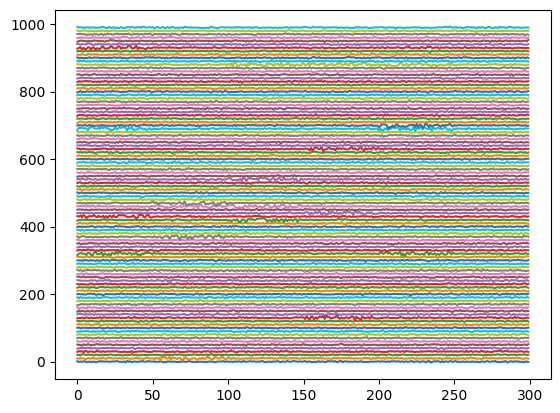

In [7]:
epoch, slices = epoch_from_transitions(transitions[0, :, :], 50, 100)
for i, ch_data in enumerate(epoch):
    plt.plot(ch_data + i*10)

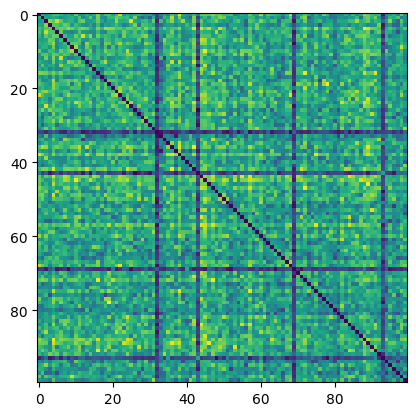

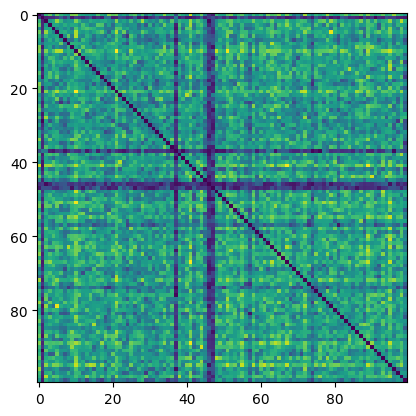

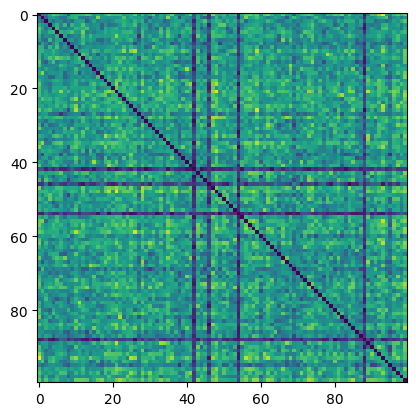

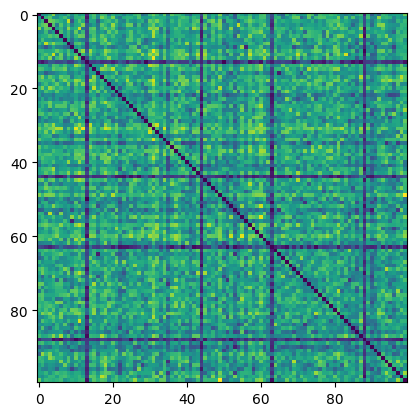

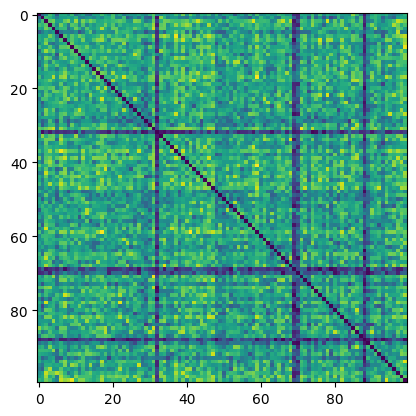

In [8]:


for slice_ in slices:
    connectome = connectivity(epoch[:, slice_], plv)
    # connectome = connectivity(epoch[:, slice_], lambda x, y: sp.signal.coherence(x, y)[1].mean())
    for i in range(len(connectome)):
        connectome[i, i] = 0
    plt.imshow(connectome)
    plt.show()


In [ ]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch

class BiConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, window_size, n_latent = None, overlap=0, stride=1, padding=0, bias=True):
        super().__init__()
        self.n_channels = in_channels
        self.window_size = window_size
        self.n_latent = n_latent if n_latent is not None else window_size // 2
        self.overlap = overlap
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.empty(self.n_channels, self.window_size, self.n_latent, out_channels))

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def forward(self, X):
        # inputs shape ~ (N_batch, n_channels, n_times)
        X_part1 = X[:, :, :-(self.window_size - self.overlap)] # shape: (batches, n_channels, times)
        X_part2 = X[:, :, self.window_size - self.overlap:,]

        assert X_part1.shape == X_part2.shape, f'Windowed sequence is corrupted: {X_part1.shape} vs {X_part2.shape}'

        convargs = ((X_part1.shape[-1], X_part1.shape[0]), self.window_size, self.padding, self.stride)
        n_windows = compute_output_shape(*convargs)[0]
        out_tensor = torch.zeros(X.shape[0], n_windows, self.weight.shape[-1]) # ~ batches x n_windows x out_channels

        # iter over neurons
        for n_neuron in range(self.weight.shape[-1]):
            for p, q, k in conviter(*convargs):
                # print(p, '|', q, '|', k)
                # p shape: n_times, ...
                # q shape: n_windows, ...
                # k shape: window_size, ...
                time_range = p[0]
                window_range = k[0]
                n_window = q[0]

                window1 = X_part1[:, :, time_range]
                window2 = X_part2[:, :, time_range]
                weight = self.weight[:, window_range, :, n_neuron]

                proj1 = torch.matmul(window1, weight) # (N batch x time_range) @ (window_range x latent_dim x n_neuron) = (N batch x latent_dim)
                proj2 = torch.matmul(window2, weight)
                cov = torch.mean(
                    (proj1 - torch.mean(proj1, 1, keepdim=True))*
                    (proj2 - torch.mean(proj2, 1, keepdim=True)),
                    1,
                    keepdim=True
                ) # ~ (N_batch, 1)
                # out_tensor[:, q, n_neuron] = cov + self.bias[n_neuron]
                out_tensor[:, n_window, n_neuron] = torch.squeeze(cov, -1) + self.bias[n_neuron] if self.bias is not None else cov


        return out_tensor

In [208]:
a = torch.rand(100, 204, 20)

b = torch.rand(20, 10)

(a@b).shape

torch.Size([100, 204, 10])

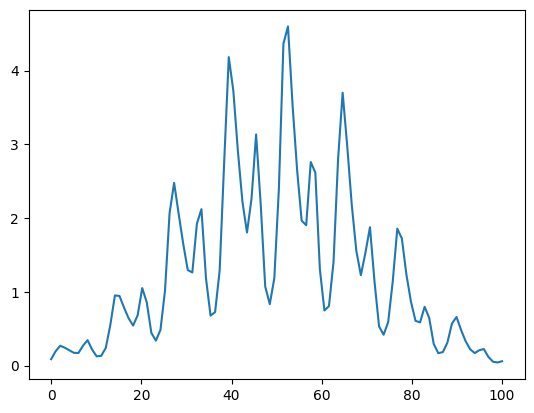

In [70]:
t = np.linspace(0, 100, 100)

y = (
        np.exp(
            np.sin(t/2)
        ) + np.exp(
            np.sin(t)
        )
    ) * np.exp(
        -(t - 50)**2 / (2 * 20**2)
    )

plt.plot(t, y)

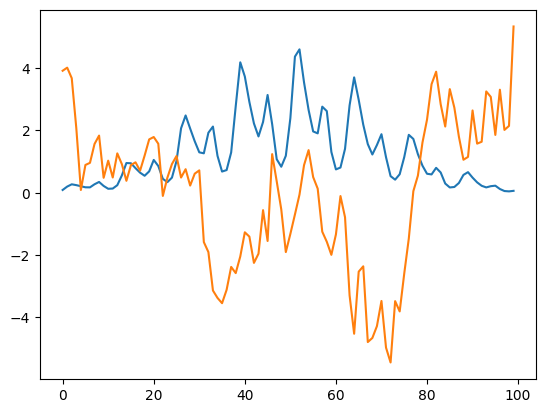

In [72]:
original_sig = y#gaussian_random_walk(100)
additional_sig = sp.signal.detrend(gaussian_random_walk(100))

plt.plot(original_sig)
plt.plot(additional_sig)

In [78]:
gains = [.5, .2, .5, .3]
gains_additional = [.2, .2, .5, .4]
noise_ratio = [.1, .8, .4, .2]

channels = list()
for g1, g2, n in zip(gains, gains_additional, noise_ratio):
    channels.append(original_sig*g1 + additional_sig*g2 + n*np.random.normal(0, 1, 100))


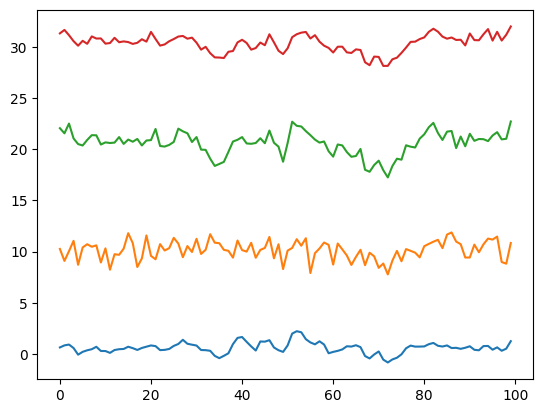

In [79]:
for i, channel in enumerate(channels):
    plt.plot(channel + 10*i)
plt.show()